In [8]:
from data_loader import read_json_as_df

import os
import scipy
import numpy as np
import pandas as pd
import sklearnsk as sksk
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV

pd.options.display.max_colwidth = 200 

In [3]:
train_df = read_json_as_df('Data/clpsych16-train.json')
test_df = read_json_as_df('Data/clpsych16-test.json')

In [23]:
class postClassifier(sksk.ConfigurableAlgorithm):
    
    def get_default_config(self):
        return {
            'algorithm': 'SVC',
            'kernel':'rbf',
            'C': 1, 
            'gamma': 'scale',
            'class_weight':'balanced',
            'ngrams': [1,1]
        }
    
    def get_custom_config_param_names(self):
        return ['ngrams']
    
    def build_feature_vectors(self, items, labelsOrScores=None):
        
        isTraining = labelsOrScores is not None
        
        if isTraining:
            vectorizer = TfidfVectorizer(ngram_range=self.config['ngrams'])
            features = vectorizer.fit_transform(items)
        else:
            features = vectorizer.transform(items)
            
        return features
    
    def handle_loaded_data(self):
        pass
    def prepare_saved_data(self):
        pass

class postTuner(sksk.RandomParameterSearcher):
    
    def initialize_algorithm(self, config):
        return postClassifier(config)
    
class evaluator(sksk.Evaluator):
    
    def initialize_algorithm(self, config):
        return postClassifier(config)
     
tuner = postTuner(
    items=train_df.text, 
    labels=train_df.priority,
    scorer='f1_score',
    scorer_config = {
        'average': 'macro',
        'labels': ['escalate','red','amber']
    }
)

In [24]:
param_space = {
    'algorithm': ['SVC'],
    'kernel':['rbf'],
    'C': scipy.stats.expon(scale=10), 
    'gamma': scipy.stats.expon(scale=0.1),
    'class_weight':['balanced',None],
    'ngrams':[[1,1], [1,2], [1,3]]
}

if not os.path.exists('tuning'):
    os.mkdir('tuning')

svc_search_record = sksk.ParameterSearchRecord('tuning/clpsych_svc_tuning.pkl')

bestConf, bestScore = tuner.do_search(param_space, svc_search_record, budget=1000, n_folds=5)

  0%|                           | 0/5000 [00:00<?, ?it/s]

 - recovered 0 previously searched parameter permutations
 - best score so far is None


  0%|                           | 0/5000 [00:00<?, ?it/s]


UnboundLocalError: local variable 'vectorizer' referenced before assignment

In [ ]:
print('best score is {}, obtained with:'.format(bestScore))

for (key, val) in bestConf.items():
    print("  {} = {}".format(key, val))

In [ ]:
    
visualizer = sksk.ParameterSearchVisualizer()

visualizer.visualize_random_search(
    svc_search_record, 
    x_axis='gamma', 
    y_axis='C', 
    filter_by={'maxSubjectFeatures':None, 'maxBodyFeatures':None},
    figsize=(8, 6)
)

In [ ]:
class PostEvaluator(sksk.Evaluator):
    
    def initialize_algorithm(self, config):
        
        return PostClassifier(config)
    
evaluator = PostEvaluator(train_df.text, train_df.priority)

configs = []
configs.append(sksk.merge_configs({'id':'tuned svm'}, bestConf))
configs.append({'id':'untuned svm'})

results = evaluator.evaluate_with_testset(configs, test_df.text, test_df.priority)
scoreTable = pd.DataFrame.from_dict(results.scores).transpose()
print(scoreTable)

Mean: 411.0960929250264 
Median: 218.0 
Std: 600.4321149494463 


{'whiskers': [<matplotlib.lines.Line2D at 0x129a4983fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x129a49a7748>,
 'boxes': [<matplotlib.lines.Line2D at 0x129a4983e80>],
 'medians': [<matplotlib.lines.Line2D at 0x129a49a7e48>],
 'fliers': [<matplotlib.lines.Line2D at 0x129a49c3208>],
 'means': []}

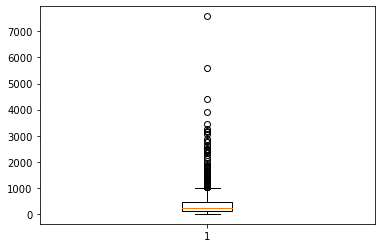

In [3]:
text_lengths = np.array([len(sent) for sent in train_df.text])

print(f'Mean: {np.mean(text_lengths)} \nMedian: {np.median(text_lengths)} \nStd: {np.std(text_lengths)} ')

plt.boxplot(text_lengths)

Mean: 402.1701244813278 
Median: 251.0 
Std: 516.6792066581842 


{'whiskers': [<matplotlib.lines.Line2D at 0x129a4cd1748>,
 'caps': [<matplotlib.lines.Line2D at 0x129a4cd1e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x129a4cd15f8>],
 'medians': [<matplotlib.lines.Line2D at 0x129a4ce45c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x129a4ce4908>],
 'means': []}

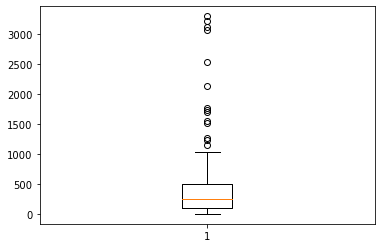

In [4]:
text_lengths = np.array([len(sent) for sent in test_df.text])

print(f'Mean: {np.mean(text_lengths)} \nMedian: {np.median(text_lengths)} \nStd: {np.std(text_lengths)} ')

plt.boxplot(text_lengths)

In [5]:
train_df.priority.value_counts()

green       549
amber       249
red         110
escalate     39
Name: priority, dtype: int64

In [6]:
test_df.priority.value_counts()

green       166
amber        47
red          27
escalate      1
Name: priority, dtype: int64

In [53]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))

# Initial model creation without using test set

In [54]:
features = vectorizer.fit_transform(train_df.text)

In [55]:
features.shape

(947, 41976)

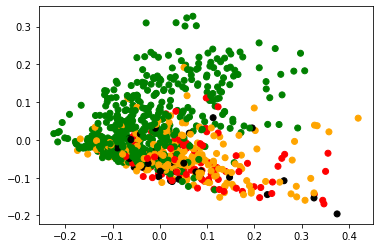

In [56]:
dense_features = features.todense()

pca = PCA(n_components=2).fit(dense_features)

features_2d = pca.transform(dense_features)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=train_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

In [57]:
%%time
# X_train, X_test, y_train, y_test = train_test_split(features, 
#                                                     train_df.priority,
#                                                     test_size=0.3,
#                                                     # random_state=4,
#                                                     stratify=train_df.priority)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)


params = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1), 'kernel': ['rbf'], 'class_weight':['balanced']}

clf = RandomizedSearchCV(estimator=SVC(),
                         param_distributions=params,
                         n_jobs=-1,
                         scoring='f1_macro',
                         cv=5,
                         n_iter=100)

searched_clf = clf.fit(features, train_df.priority)

print('Best Params:', searched_clf.best_params_, '\n')
print('Best macro avg F1 score:', searched_clf.best_score_, '\n')
print(searched_clf.best_estimator_, '\n')



Best Params: {'C': 31.409773183084354, 'class_weight': 'balanced', 'gamma': 0.009963127624352735, 'kernel': 'rbf'} 

Best macro avg F1 score: 0.4595593959308773 

SVC(C=31.409773183084354, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.009963127624352735, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False) 

Wall time: 1min 4s


# Main method to train and test classifier

In [47]:
def run_tfidf_svc(clf, xtrain, ytrain, xtest, ytest):
    
    vectorizer = TfidfVectorizer()
    
    train_features = vectorizer.fit_transform(xtrain)
    test_features = vectorizer.transform(xtest)
    
    print(f'Training feature size: {train_features.shape} \nTesting feature size: {test_features.shape}\n')
    
    print(clf, '\n')
    
    clf.fit(train_features, ytrain)
    
    predicted_priority = clf.predict(test_features)

    print('Classification Report:\n', classification_report(ytest, predicted_priority))
    
    

# Train and test on full datasets

## Official - ignoring 'green' priority

In [48]:

official_train_df = train_df[train_df.priority != 'green']
official_test_df = test_df[test_df.priority != 'green']

run_tfidf_svc(clf = searched_clf.best_estimator_,
              xtrain = official_train_df.text,
              ytrain = official_train_df.priority,
              xtest = official_test_df.text,
              ytest = official_test_df.priority)


Training feature size: (398, 3698) 
Testing feature size: (75, 3698)

SVC(C=27.727287550818158, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.009300920403778523, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False) 

Classification Report:
               precision    recall  f1-score   support

       amber       0.81      0.72      0.76        47
    escalate       0.00      0.00      0.00         1
         red       0.60      0.67      0.63        27

    accuracy                           0.69        75
   macro avg       0.47      0.46      0.47        75
weighted avg       0.72      0.69      0.71        75



## Flagged - 'crisis + red + amber' as flagged vs 'green'

In [49]:
flagged_train_df = train_df.copy()
flagged_test_df = test_df.copy()

flagged_train_df.priority = flagged_train_df.priority.replace(to_replace=['red', 'escalate', 'amber'], value='flagged')
flagged_test_df.priority = flagged_test_df.priority.replace(to_replace=['red', 'escalate', 'amber'], value='flagged')

print(flagged_train_df.priority.value_counts(), '\n')
print(flagged_test_df.priority.value_counts(), '\n')

run_tfidf_svc(clf = searched_clf.best_estimator_,
              xtrain = flagged_train_df.text,
              ytrain = flagged_train_df.priority,
              xtest = flagged_test_df.text,
              ytest = flagged_test_df.priority)



green      549
flagged    398
Name: priority, dtype: int64 

green      166
flagged     75
Name: priority, dtype: int64 

Training feature size: (947, 5379) 
Testing feature size: (241, 5379)

SVC(C=27.727287550818158, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.009300920403778523, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False) 

Classification Report:
               precision    recall  f1-score   support

     flagged       0.74      0.89      0.81        75
       green       0.95      0.86      0.90       166

    accuracy                           0.87       241
   macro avg       0.85      0.88      0.86       241
weighted avg       0.88      0.87      0.87       241



## Urgent - 'red + escalate' as urgent vs 'amber + green' as non_urgent

In [50]:
urgent_train_df = train_df.copy()
urgent_test_df = test_df.copy()

urgent_train_df.priority = urgent_train_df.priority.replace(to_replace=['red', 'escalate'], value='urgent')
urgent_train_df.priority = urgent_train_df.priority.replace(to_replace=['green', 'amber'], value='non_urgent')

urgent_test_df.priority = urgent_test_df.priority.replace(to_replace=['red', 'escalate'], value='urgent')
urgent_test_df.priority = urgent_test_df.priority.replace(to_replace=['green', 'amber'], value='non_urgent')

print(urgent_train_df.priority.value_counts(), '\n')
print(urgent_test_df.priority.value_counts(), '\n')

run_tfidf_svc(clf = searched_clf.best_estimator_,
              xtrain = urgent_train_df.text,
              ytrain = urgent_train_df.priority,
              xtest = urgent_test_df.text,
              ytest = urgent_test_df.priority)


non_urgent    798
urgent        149
Name: priority, dtype: int64 

non_urgent    213
urgent         28
Name: priority, dtype: int64 

Training feature size: (947, 5379) 
Testing feature size: (241, 5379)

SVC(C=27.727287550818158, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.009300920403778523, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False) 

Classification Report:
               precision    recall  f1-score   support

  non_urgent       0.97      0.90      0.93       213
      urgent       0.51      0.82      0.63        28

    accuracy                           0.89       241
   macro avg       0.74      0.86      0.78       241
weighted avg       0.92      0.89      0.90       241



## Full dataset with individual categories

In [51]:
run_tfidf_svc(clf = searched_clf.best_estimator_,
              xtrain = train_df.text,
              ytrain = train_df.priority,
              xtest = test_df.text,
              ytest = test_df.priority)

Training feature size: (947, 5379) 
Testing feature size: (241, 5379)

SVC(C=27.727287550818158, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.009300920403778523, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False) 

Classification Report:
               precision    recall  f1-score   support

       amber       0.52      0.66      0.58        47
    escalate       0.00      0.00      0.00         1
       green       0.95      0.85      0.90       166
         red       0.55      0.63      0.59        27

    accuracy                           0.78       241
   macro avg       0.50      0.53      0.52       241
weighted avg       0.82      0.78      0.80       241



# Temp Rough Work

In [16]:
# train_features = vectorizer.fit_transform(train_df.text)

# test_features = vectorizer.transform(test_df[test_df.priority != 'green'].text)

# print(train_features.shape, train_df.priority.shape)
# print(test_features.shape, test_df[test_df.priority != 'green'].priority.shape, '\n')

# svc_clf = SVC(class_weight='balanced')

# print(svc_clf, '\n')

# svc_clf.fit(train_features, train_df.priority)

# predicted_priority = svc_clf.predict(test_features)

# print(classification_report(test_df[test_df.priority != 'green'].priority, predicted_priority))